# Spotify Listening Activity Analysis
### Research Question:
#### Do a song's audio features (danceability, instrumentalness, valence, energy, tempo) impact my listening activity?


In [1]:
# import modules
import pandas as pd
import numpy as np
import random
import re
from pandas.io.json import json_normalize
import json
import spotipy
import requests
import matplotlib.pyplot as plt
%matplotlib inline

# Streaming History DataFrame (downloaded JSON from Spotify)

In [2]:
# read in json from streaming activity data
df = pd.read_json(r'/Users/cole/Desktop/INST414/ThinkStats2-master-Final Project/Final Project/Spotify Data-Final_Project_2/StreamingHistory0.json')
df1 = pd.read_json(r'/Users/cole/Desktop/INST414/ThinkStats2-master-Final Project/Final Project/Spotify Data-Final_Project_2/StreamingHistory1.json')
df2 = pd.read_json(r'/Users/cole/Desktop/INST414/ThinkStats2-master-Final Project/Final Project/Spotify Data-Final_Project_2/StreamingHistory2.json')
df3 = pd.read_json(r'/Users/cole/Desktop/INST414/ThinkStats2-master-Final Project/Final Project/Spotify Data-Final_Project_2/StreamingHistory3.json')
df4 = pd.read_json(r'/Users/cole/Desktop/INST414/ThinkStats2-master-Final Project/Final Project/Spotify Data-Final_Project_2/StreamingHistory4.json')
library = pd.read_json(r'/Users/cole/Desktop/INST414/ThinkStats2-master-Final Project/Final Project/Spotify Data-Final_Project_2/YourLibraryClean.json')

# convert json to CSV file
df.to_csv(r'/Users/cole/Desktop/INST414/ThinkStats2-master-Final Project/Final Project/Spotify Data-Final_Project_2/StreamingHistory0.csv', index = False)
df1.to_csv(r'/Users/cole/Desktop/INST414/ThinkStats2-master-Final Project/Final Project/Spotify Data-Final_Project_2/StreamingHistory1.csv', index = False)
df2.to_csv(r'/Users/cole/Desktop/INST414/ThinkStats2-master-Final Project/Final Project/Spotify Data-Final_Project_2/StreamingHistory2.csv', index = False)
df3.to_csv(r'/Users/cole/Desktop/INST414/ThinkStats2-master-Final Project/Final Project/Spotify Data-Final_Project_2/StreamingHistory3.csv', index = False)
df4.to_csv(r'/Users/cole/Desktop/INST414/ThinkStats2-master-Final Project/Final Project/Spotify Data-Final_Project_2/StreamingHistory4.csv', index = False)
library.to_csv(r'/Users/cole/Desktop/INST414/ThinkStats2-master-Final Project/Final Project/Spotify Data-Final_Project_2/YourLibraryClean.csv', index = False)

In [3]:
# Merge df1, df2, df3, df4, and library into one dataframe
streamingHistory = pd.concat([df,df1,df2,df3,df4])

# streamingHistory ID column
streamingHistory['UniqueID'] = streamingHistory['artistName'] + ": " + streamingHistory['trackName']
streamingHistory.to_csv(r'/Users/cole/Desktop/INST414/ThinkStats2-master-Final Project/Final Project/Spotify Data-Final_Project_2/allStreamingHistory.csv', index = False)

In [4]:
# columns:
# endTime = date and time when the stream ended in UTC format
# artistName = artist name if a music track
# title of music track or name of video
# msPlayed = how many mili-seconds the track was listened to
# ID = "artistName: trackName"

streamingHistory.head()

,endTime,artistName,trackName,msPlayed,UniqueID
0,2021-10-21 17:58,TTRRUUCES,Sensations of Cool,27125,TTRRUUCES: Sensations of Cool
1,2021-11-18 00:59,Guantanamo Bay Surf Club,Halves and Quarters,272925,Guantanamo Bay Surf Club: Halves and Quarters
2,2021-11-18 03:39,The Growlers,Too Many Times,232584,The Growlers: Too Many Times
3,2021-11-18 03:43,Eric Clapton,Cocaine,4202,Eric Clapton: Cocaine
4,2021-11-18 03:43,The Growlers,Night Ride,240023,The Growlers: Night Ride


In [5]:
# add UniqueID column (same as above)
library['UniqueID'] = library['artist'] + ": " + library['track']

# add column with track URI stripped of 'spotify:track:'
new = library["uri"].str.split(":", expand = True)
library['track_uri'] = new[2]

library.head()

,artist,album,track,uri,UniqueID,track_uri
0,49th & Main,Catching Eyes,Catching Eyes,spotify:track:2aUYt0CwHeJLrlgi0akUGp,49th & Main: Catching Eyes,2aUYt0CwHeJLrlgi0akUGp
1,"Tyler, The Creator",Flower Boy,See You Again (feat. Kali Uchis),spotify:track:7KA4W4McWYRpgf0fWsJZWB,"Tyler, The Creator: See You Again (feat. Kali ...",7KA4W4McWYRpgf0fWsJZWB
2,Bazzi,Soul Searching,I.F.L.Y.,spotify:track:4a6q8CR2hzLk2plDkSxkfD,Bazzi: I.F.L.Y.,4a6q8CR2hzLk2plDkSxkfD
3,Quality Control,Quality Control: Control The Streets Volume 1,We The Ones,spotify:track:6Eoz2eZzrDV0AhzJxfqkFg,Quality Control: We The Ones,6Eoz2eZzrDV0AhzJxfqkFg
4,2Pac,Me Against The World,Old School,spotify:track:4GGbJ60q5HIN8wKOp9Xabz,2Pac: Old School,4GGbJ60q5HIN8wKOp9Xabz


In [6]:
listentingActivity = streamingHistory.copy()

# checks if streamed song is in library
listentingActivity['In Library'] = np.where(listentingActivity['UniqueID'].isin(library['UniqueID'].tolist()),'Yes','No')

# left join with df_library on UniqueID to bring in album and track_uri
listeningActivity = pd.merge(listentingActivity,library[['album','UniqueID','track_uri']],how='left',on=['UniqueID'])

listeningActivity.head()

,endTime,artistName,trackName,msPlayed,UniqueID,In Library,album,track_uri
0,2021-10-21 17:58,TTRRUUCES,Sensations of Cool,27125,TTRRUUCES: Sensations of Cool,Yes,TTRRUUCES,4SfyAvpcSQxijDWXLQd57b
1,2021-11-18 00:59,Guantanamo Bay Surf Club,Halves and Quarters,272925,Guantanamo Bay Surf Club: Halves and Quarters,Yes,Guantanamo Bay Surf Club,6dL42lbkjANNaZCbO9FBTp
2,2021-11-18 03:39,The Growlers,Too Many Times,232584,The Growlers: Too Many Times,Yes,City Club,0EHGQN0jJ0oDtDGDTKWCBm
3,2021-11-18 03:43,Eric Clapton,Cocaine,4202,Eric Clapton: Cocaine,Yes,Slowhand 35th Anniversary,3ykSdTGmYPFl8pDBXer1zG
4,2021-11-18 03:43,The Growlers,Night Ride,240023,The Growlers: Night Ride,No,NaN,NaN


In [7]:
top_artists = listeningActivity[["artistName","trackName"]].groupby(["artistName"]).agg("count")
top_artists = top_artists.reset_index()
top_artists.columns = ["artistName","num_of_times_played"]
top_artists = top_artists.sort_values(['num_of_times_played'], ascending=False)
top_artists.head(20)

,artistName,num_of_times_played
1568,Lime Cordiale,1666
2724,The Growlers,1091
2855,The Walters,447
1232,JAY-Z,446
923,Felly,427
1665,Mac Miller,423
1408,Kanye West,406
2055,Peach Pit,381
2662,The Beatles,375
2543,Summer Salt,346


In [8]:
top_songs = listeningActivity[["trackName","track_uri","artistName"]].groupby(["trackName", "track_uri"]).agg("count")
top_songs = top_songs.reset_index()
top_songs.columns = ["trackName","track_uri","num_of_times_played"]
top_songs = top_songs.sort_values(['num_of_times_played'], ascending=False)
top_songs

,trackName,track_uri,num_of_times_played
770,Country Club,6nqKsUL0Fd3BQsmQYbh8Zb,267
265,Baby Bay,7tLTovSYbfwkz2GhdCEGrF,173
1348,Give Up Baby Go,6DIMM15oo3kxnCuVypaYGy,157
2439,Nightride,553cXGLHlFjP83AuE1SSlC,157
682,Clap Your Hands,6jcfITWcR5egvbD4fsGayr,155
...,...,...,...
1392,Good Drank,1JWsD33y51ZlsXPlFDTYv2,1
2525,Oh My Dis Side (feat. Quavo),2rMFawCg4BW65jzbwztXAV,1
1390,Good Day,5pBQDRgfbV6lhuwlvWEftN,1
1386,Gone (The Pocahontas Song),6m8mbyoMIs5Tg8HNfStrjQ,1


In [9]:
top_songs.to_csv(r'/Users/cole/Desktop/INST414/ThinkStats2-master-Final Project/Final Project/Spotify Data-Final_Project_2/top_songs.csv', index = False)
all_top_songs = pd.read_csv('/Users/cole/Desktop/INST414/ThinkStats2-master-Final Project/Final Project/Spotify Data-Final_Project_2/top_songs.csv')
all_top_songs


,trackName,track_uri,num_of_times_played
0,Country Club,6nqKsUL0Fd3BQsmQYbh8Zb,267
1,Baby Bay,7tLTovSYbfwkz2GhdCEGrF,173
2,Give Up Baby Go,6DIMM15oo3kxnCuVypaYGy,157
3,Nightride,553cXGLHlFjP83AuE1SSlC,157
4,Clap Your Hands,6jcfITWcR5egvbD4fsGayr,155
...,...,...,...
4291,Good Drank,1JWsD33y51ZlsXPlFDTYv2,1
4292,Oh My Dis Side (feat. Quavo),2rMFawCg4BW65jzbwztXAV,1
4293,Good Day,5pBQDRgfbV6lhuwlvWEftN,1
4294,Gone (The Pocahontas Song),6m8mbyoMIs5Tg8HNfStrjQ,1


# Using the Spotify API (Spotipy)

In [10]:
from spotipy.oauth2 import SpotifyOAuth

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(username='insert username',
                                               client_id="insert client id",
                                               client_secret="insert client secret",
                                               redirect_uri="http://localhost:9999/callback",
                                               scope="user-library-read"))

In [11]:
audio_features_top_songs = sp.audio_features(tracks=['6nqKsUL0Fd3BQsmQYbh8Zb', '7tLTovSYbfwkz2GhdCEGrF', '6DIMM15oo3kxnCuVypaYGy', '553cXGLHlFjP83AuE1SSlC', '6jcfITWcR5egvbD4fsGayr', '35m0zFQz1RgVQsUwegOyzf', '4BeCUz9P89lrIIHY1O8Cyu', '1xZOYV0Z6i7z0nAnyL1zmT', '2NZYvSyWHdR2QgXvOpFY49', '2TlJJD05H1CFTYKfT0zfTT', '2QPRyuSM1lKSSIRSrpFlDH', '5ReLOUboXvaOVariwEJnl3', '2RUqw1MzyHaBv6f0hFpjfB', '2rNy5Ils7RO6m2E2W83CR5', '6zO5bXeQs4RS5OTj9KGUV4', '3YXIVMQLRRq2K7kxC7UYx6', '5A5bLKdL5I3k3FTEQlAUw7', '154YAkNQuFHLV3LbP7gP1f', '3ktvmVum7GbzwsUSIcHbWI', '1yiKEvsWURV5lAc2rs22Qq', '6ApvETfR03Th0uFdTBzzTh', '4ASOMWcJUrwEpjJy4GEijz', '2ddm4Ghw3wHpt8xCtr11cZ', '1c9aoDXHF5SN0LFN3da4em', '2lqL7EkTUsjdscJ7WL70fE', '0Lo1XhbYckvtAnd1CJb39V', '16cDPu788AGATCvvvcdr7N', '37ZDfygEHF7SMoYGDqM1uv', '3YC7FYhduZbYObLRCdhANa', '1hzh9Hz7urXIxfH0WztWI2', '2q4IaFpqebD6pMLvRrclvO', '7p15pjKeiHuxFg7cu776sl', '12GjmbiH5r7egMoZkf6lS8', '7xlv2NG7uJhBce2ENwkIx0', '4ozcKJYg9jNsuBTZCD6PpA', '439X8jGytErRiPnaoUJHju', '5msFXipAG1CsK92OakSAbS', '4JQd6l2cdENwRUr1bELt2T', '1hGy2eLcmC8eKx7qr1tOqx', '0dZlON0G0od05O549PikZU', '5B4gUqNKYgU38ULSWP5Bzj', '4gg4uUTRXXRUMFs8qO3C2g', '1rkczjrPToWgR7ldFn2fzu', '2Vi8BQIM9vCQkkrvf3VPjI', '2MWoG6ZINVavRRNNrVPplf', '3kBofOTKMUZ62a311eUwvx', '0bmirxniiT3qSMbDVYy8J0', '38HvJkH21S2bRciZHohv68', '4mecsNmhhWzNmgW63Joyyn', '5ev47QYsBU46zhjnHC3Jmh',])

In [12]:
# convert list to dataframe
audio_features_top_songs = pd.DataFrame(audio_features_top_songs)
audio_features_top_songs.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.643,0.665,1,-7.254,0,0.1040,0.0637,0.000000,0.1160,0.806,176.009,audio_features,6nqKsUL0Fd3BQsmQYbh8Zb,spotify:track:6nqKsUL0Fd3BQsmQYbh8Zb,https://api.spotify.com/v1/tracks/6nqKsUL0Fd3B...,https://api.spotify.com/v1/audio-analysis/6nqK...,209765,4
1,0.606,0.549,7,-10.584,1,0.0346,0.6450,0.000019,0.2160,0.924,127.960,audio_features,7tLTovSYbfwkz2GhdCEGrF,spotify:track:7tLTovSYbfwkz2GhdCEGrF,https://api.spotify.com/v1/tracks/7tLTovSYbfwk...,https://api.spotify.com/v1/audio-analysis/7tLT...,134518,4
2,0.683,0.697,9,-6.703,1,0.0250,0.1690,0.000002,0.0527,0.591,96.729,audio_features,6DIMM15oo3kxnCuVypaYGy,spotify:track:6DIMM15oo3kxnCuVypaYGy,https://api.spotify.com/v1/tracks/6DIMM15oo3kx...,https://api.spotify.com/v1/audio-analysis/6DIM...,257007,4
3,0.812,0.442,4,-13.451,0,0.1470,0.9180,0.000849,0.1200,0.832,128.966,audio_features,553cXGLHlFjP83AuE1SSlC,spotify:track:553cXGLHlFjP83AuE1SSlC,https://api.spotify.com/v1/tracks/553cXGLHlFjP...,https://api.spotify.com/v1/audio-analysis/553c...,117413,4
4,0.878,0.875,1,-4.923,1,0.0658,0.0507,0.000034,0.3560,0.840,124.006,audio_features,6jcfITWcR5egvbD4fsGayr,spotify:track:6jcfITWcR5egvbD4fsGayr,https://api.spotify.com/v1/tracks/6jcfITWcR5eg...,https://api.spotify.com/v1/audio-analysis/6jcf...,189880,4


In [13]:
audio_features_top_songs.shape

(50, 18)

In [14]:
# merge top_songs and audio_features_top_songs to one dataframe
top_tracks = pd.merge(audio_features_top_songs, top_songs[['track_uri','trackName','num_of_times_played']], left_on='id', right_on='track_uri')
top_tracks = top_tracks.sort_values(['num_of_times_played'], ascending=False)
top_tracks.head()


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,track_uri,trackName,num_of_times_played
0,0.643,0.665,1,-7.254,0,0.1040,0.0637,0.000000,0.1160,0.806,...,audio_features,6nqKsUL0Fd3BQsmQYbh8Zb,spotify:track:6nqKsUL0Fd3BQsmQYbh8Zb,https://api.spotify.com/v1/tracks/6nqKsUL0Fd3B...,https://api.spotify.com/v1/audio-analysis/6nqK...,209765,4,6nqKsUL0Fd3BQsmQYbh8Zb,Country Club,267
1,0.606,0.549,7,-10.584,1,0.0346,0.6450,0.000019,0.2160,0.924,...,audio_features,7tLTovSYbfwkz2GhdCEGrF,spotify:track:7tLTovSYbfwkz2GhdCEGrF,https://api.spotify.com/v1/tracks/7tLTovSYbfwk...,https://api.spotify.com/v1/audio-analysis/7tLT...,134518,4,7tLTovSYbfwkz2GhdCEGrF,Baby Bay,173
2,0.683,0.697,9,-6.703,1,0.0250,0.1690,0.000002,0.0527,0.591,...,audio_features,6DIMM15oo3kxnCuVypaYGy,spotify:track:6DIMM15oo3kxnCuVypaYGy,https://api.spotify.com/v1/tracks/6DIMM15oo3kx...,https://api.spotify.com/v1/audio-analysis/6DIM...,257007,4,6DIMM15oo3kxnCuVypaYGy,Give Up Baby Go,157
3,0.812,0.442,4,-13.451,0,0.1470,0.9180,0.000849,0.1200,0.832,...,audio_features,553cXGLHlFjP83AuE1SSlC,spotify:track:553cXGLHlFjP83AuE1SSlC,https://api.spotify.com/v1/tracks/553cXGLHlFjP...,https://api.spotify.com/v1/audio-analysis/553c...,117413,4,553cXGLHlFjP83AuE1SSlC,Nightride,157
4,0.878,0.875,1,-4.923,1,0.0658,0.0507,0.000034,0.3560,0.840,...,audio_features,6jcfITWcR5egvbD4fsGayr,spotify:track:6jcfITWcR5egvbD4fsGayr,https://api.spotify.com/v1/tracks/6jcfITWcR5eg...,https://api.spotify.com/v1/audio-analysis/6jcf...,189880,4,6jcfITWcR5egvbD4fsGayr,Clap Your Hands,155


In [15]:
top_tracks.shape

(50, 21)

In [16]:
# save final dataset to csv
top_tracks.to_csv(r'/Users/cole/Desktop/INST414/ThinkStats2-master-Final Project/Final Project/Spotify Data-Final_Project_2/TopTracks.csv', index = False)


## Research Question
### 1. Do a song's audio features (tempo, danceability, energy, acousticness, valence) impact my listening activity?

#### Statistical Analysis and Machine Learning

• **tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
<br>
<br>
• **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
<br>
<br>
• **energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
<br>
<br>
• **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
<br>
<br>
• **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
<br>
<br>
<br>
Source:
<br>
Spotify. (n.d.). Web API Reference | Spotify for Developers. Developer.spotify.com. https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features

### Scatter Plots

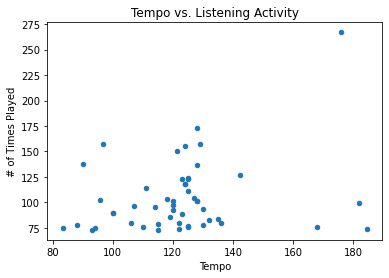

In [17]:
tempoScatter = (top_tracks.plot.scatter(x='tempo', y='num_of_times_played'),
plt.xlabel('Tempo'), plt.ylabel('# of Times Played'), plt.title('Tempo vs. Listening Activity'))

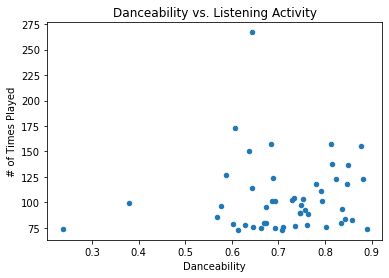

In [18]:
danceabilityScatter = (top_tracks.plot.scatter(x='danceability', y='num_of_times_played'),
plt.xlabel('Danceability'), plt.ylabel('# of Times Played'), plt.title('Danceability vs. Listening Activity'))

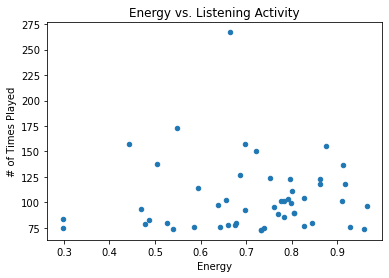

In [19]:
energyScatter = (top_tracks.plot.scatter(x='energy', y='num_of_times_played'),
plt.xlabel('Energy'), plt.ylabel('# of Times Played'), plt.title('Energy vs. Listening Activity'))

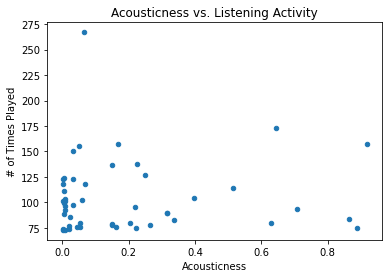

In [20]:
acousticnessScatter = (top_tracks.plot.scatter(x='acousticness', y='num_of_times_played'),
plt.xlabel('Acousticness'), plt.ylabel('# of Times Played'), plt.title('Acousticness vs. Listening Activity'))

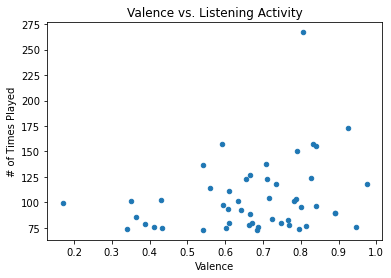

In [21]:
valenceScatter = (top_tracks.plot.scatter(x='valence', y='num_of_times_played'),
plt.xlabel('Valence'), plt.ylabel('# of Times Played'), plt.title('Valence vs. Listening Activity'))

### Machine Learning Analysis

In [22]:
top_tracks_file_path = '/Users/cole/Desktop/INST414/ThinkStats2-master-Final Project/Final Project/Spotify Data-Final_Project_2/TopTracks.csv'
top_tracks_data = pd.read_csv(top_tracks_file_path) 
top_tracks_data.columns



Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'track_uri', 'trackName', 'num_of_times_played'],
      dtype='object')

In [23]:
y = top_tracks_data.num_of_times_played
top_tracks_features = ['danceability', 'energy', 'acousticness', 'valence', 'tempo']
X = top_tracks_data[top_tracks_features]
X.describe()

,danceability,energy,acousticness,valence,tempo
count,50.00000,50.00000,50.000000,50.000000,50.000000
mean,0.71412,0.71002,0.186351,0.670760,122.153200
std,0.12188,0.15945,0.253831,0.173746,21.372587
min,0.23600,0.29700,0.000366,0.170000,83.214000
25%,0.65000,0.63925,0.007540,0.595750,111.711000
50%,0.73200,0.73600,0.056850,0.685000,122.995500
75%,0.79975,0.80400,0.244000,0.794250,128.017750
max,0.89000,0.96500,0.918000,0.975000,184.644000


In [24]:
X.head()

,danceability,energy,acousticness,valence,tempo
0,0.643,0.665,0.0637,0.806,176.009
1,0.606,0.549,0.6450,0.924,127.960
2,0.683,0.697,0.1690,0.591,96.729
3,0.812,0.442,0.9180,0.832,128.966
4,0.878,0.875,0.0507,0.840,124.006


In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# define model
top_tracks_model = DecisionTreeRegressor(random_state=1)

# fit model
top_tracks_model.fit(X, y)

DecisionTreeRegressor(random_state=1)

In [26]:
print("Predictions for the following 5 tracks:")
print(X.head())
print("Predictions:")
print(top_tracks_model.predict(X.head()))

Predictions for the following 5 tracks:
   danceability  energy  acousticness  valence    tempo
0         0.643   0.665        0.0637    0.806  176.009
1         0.606   0.549        0.6450    0.924  127.960
2         0.683   0.697        0.1690    0.591   96.729
3         0.812   0.442        0.9180    0.832  128.966
4         0.878   0.875        0.0507    0.840  124.006
Predictions:
[267. 173. 157. 157. 155.]


In [27]:
# validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# define model
top_tracks_model = DecisionTreeRegressor(random_state=1)

# fit Model
top_tracks_model.fit(train_X, train_y)

DecisionTreeRegressor(random_state=1)

In [28]:
val_predictions = top_tracks_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE when not specifying max_leaf_nodes: {:,.0f}".format(val_mae))

Validation MAE when not specifying max_leaf_nodes: 14


In [29]:
# Using best value for max_leaf_nodes
iowa_model = DecisionTreeRegressor(max_leaf_nodes=100, random_state=1)
iowa_model.fit(train_X, train_y)
val_predictions = iowa_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE for best value of max_leaf_nodes: {:,.0f}".format(val_mae))

Validation MAE for best value of max_leaf_nodes: 16


### Random Forest Model

In [30]:
from sklearn.ensemble import RandomForestRegressor

# define model
random_forest_model = RandomForestRegressor()

# fit  model
random_forest_model.fit(train_X, train_y)

# mean absolute error of Random Forest model on  validation data
rf_val_predictions = random_forest_model.predict(val_X)
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)

print("Validation MAE for Random Forest Model: {}".format(rf_val_mae))

Validation MAE for Random Forest Model: 27.83923076923077
